<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C6/C6.html"><img src="../data/C6_nav.png" width="100"  style="float:right;" alt="C6"></a>
<h1>Adaptive Windowing</h1> 
</div>

<br/>

<p>
Following Section 6.3.3 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we discuss in this notebook the concept of adaptive windowing.
</p> 

## Basic Idea

One crucial step in practically all music analysis tasks consists of transforming the given audio signal into a suitable feature representation that captures certain musical properties. Since most musical properties vary over time, the given audio signal is typically split up into segments or frames, which are then further processed individually. The underlying assumption is that the signal stays (approximately) stationary within each segment with regard to the property to be captured. In practice, as is the case with the [short-time Fourier transform](../C2/C2_STFT-Basic.html) (see Section 2.5 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>), a predefined window of fixed size is used for the time localization, where the size is determined empirically and optimized for the specific application in mind. Using **fixed-size windowing**, however, may lead to a violation of the homogeneity assumption: the boundaries of the resulting windowed sections often do not coincide with the positions where the changes of the signal occur. As an alternative to fixed-size windowing, one can employ a more musically meaningful **adaptive windowing** strategy, where segment boundaries are induced by previously extracted onset and beat positions. Since musical changes typically occur at onset positions, this often leads to an increased homogeneity within the adaptively determined frames and a significant improvement in the resulting feature quality. 

## Example: C-Major Scale

<!-- For an illustration we consider an audio recording with four subsequent chords (a Phrygian half cadence in C major).
<img src="../data/C6/FMP_C6_F23a.png" width="250px" align="left" alt="FMP_C6_F23a.png">
<br clear="all" />
<audio style="width: 250px;" src="../data/C6/FMP_C6_F23_PhrygianHalfCadenceC.mp3" type="audio/mpeg" controls="controls"></audio>
<img src="../data/C6/FMP_C6_F23b-c.png" width="600px" align="middle" alt="FMP_C6_F23b-c.png">
-->

For an illustration we consider an audio recording with a C-major scale played on a piano. 

<img src="../data/C6/FMP_C6_F24_ScaleMajorC.png" width="320px" align="left" alt="FMP_C6_F24_ScaleMajorC.png">

<br clear="all" />

<audio style="width: 320px;" src="../data/C6/FMP_C6_F24_ScaleMajorC-middle.mp3" type="audio/mpeg" controls="controls"></audio>

The following figure shows a [chroma representation](../C3/C3S1_SpecLogFreq-Chromagram.html) of the audio excerpt using a fixed-size windowing. Let us have a closer look at the frame with index $n=3$ (between $t=1.5~\mathrm{sec}$ and $t=2~\mathrm{sec}$). Note that this frame contains note change leading to a rather "noisy" chroma feature where the chroma bands contain energy from the two different notes $\mathrm{D}$ and $\mathrm{E}$. 

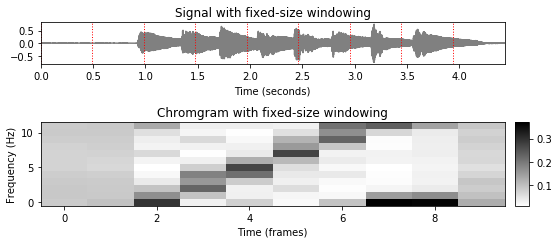

In [1]:
import numpy as np
import os, sys, librosa
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import IPython.display as ipd

sys.path.append('..')
import LibFMP.B
import LibFMP.C6
%matplotlib inline

def plot_beat_grid(B_sec, ax, color='r', linestyle=':', linewidth=1):
    """Plot beat grid (given in seconds) into axis 
    Notebook: C6S3_AdaptiveWindowing.ipynb"""    
    for b in B_sec: ax.axvline(x=b, color=color, linestyle=linestyle, linewidth=linewidth)

#fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F23_PhrygianHalfCadenceC.wav')
#fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F23_C-major-scale_fast.wav')
fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F24_ScaleMajorC-middle.wav')

Fs = 22050
x, Fs = librosa.load(fn_wav, Fs) 

N, H = 1024, 512
X = librosa.stft(y=x, n_fft=N, hop_length=H, win_length=N, center=True, window='hanning')
Y = np.abs(X)
C = librosa.feature.chroma_stft(S=Y, sr=Fs, norm=1, hop_length=H, n_fft=N)

B_num = 10
B_fix_sec = np.linspace(0, x.shape[0], B_num) / Fs
B_fix_frame = (B_fix_sec*Fs/H).astype(int)
C_fix = librosa.util.sync(C, B_fix_frame)

# Visualization
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1, 2]}, figsize=(8,3.5)) 

LibFMP.B.plot_signal(x, Fs, ax=ax[0,0], 
                     title='Signal with fixed-size windowing')
ax[0,1].set_axis_off()
plot_beat_grid(B_fix_sec, ax[0,0])
    
LibFMP.B.plot_matrix(C_fix, ax=[ax[1,0], ax[1,1]], xlabel='Time (frames)', 
                     title='Chromgram with fixed-size windowing')
plt.tight_layout()

We now introduce a function for adaptive windowing, which is informed by note onsets. As is shown by the next figure, adaptive windowing leads to clean chroma features that nicely capture the characteristics of the eight notes. We want to make some notes regarding the following implementation and example:

* We specify the time grid (in our code denoted by `B_sec`, `B_adapt_sec`, or `B_fix_sec`) in seconds.
* The function `librosa.util.sync` allows for computing a feature representation adapted to a given time grid. In this case, the time grid needs to be converted to frame indices that match the feature representation.
* In our example, we use a chroma representation computed on a fine time grid based on fixed-size windowing, which is then adapted to the coarser grid (specified by `B_adapt_sec`, or `B_fix_sec`). 
* When computing the representation on the finer grid, we use a [centered view](../C2/C2_STFT-Conventions.html), which may introduce some "bleeding" also on the coarser grid. To avoid this effect, one may use the parameter `center=False`.

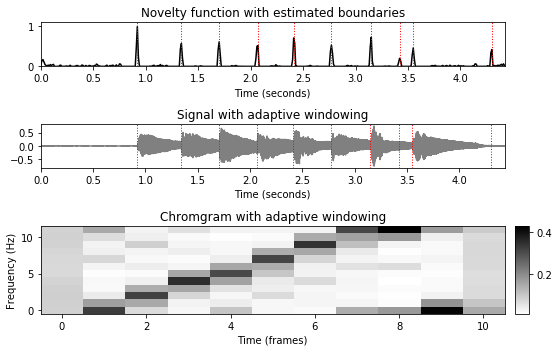

In [2]:
nov, Fs_nov = LibFMP.C6.compute_novelty_spectrum(x, Fs=Fs, N=512, H=256, 
                                                 gamma=100, M=10, norm=1)
nov, Fs_nov = LibFMP.C6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

peaks, properties = signal.find_peaks(nov, prominence=0.2)
B_adapt_sec = peaks/Fs_nov
B_adapt_frame = (B_adapt_sec*Fs/H).astype(int)
C_adapt = librosa.util.sync(C, B_adapt_frame, aggregate=np.mean)

# Visualization
fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1, 1, 2]}, figsize=(8,5)) 

LibFMP.B.plot_signal(nov, Fs_nov, color='k', ax=ax[0,0],
                    title='Novelty function with estimated boundaries')
ax[0,1].set_axis_off()
plot_beat_grid(B_adapt_sec, ax[0,0])

LibFMP.B.plot_signal(x, Fs, ax=ax[1,0],
                    title='Signal with adaptive windowing')
ax[1,1].set_axis_off()
plot_beat_grid(B_adapt_sec, ax[1,0])

LibFMP.B.plot_matrix(C_adapt, ax=[ax[2,0], ax[2,1]], xlabel='Time (frames)',
                    title='Chromgram with adaptive windowing')

plt.tight_layout()

## Beat-Synchronous Feature Representation

Adaptive windowing techniques based on beat information are of particular importance for many music analysis and retrieval applications. In this case, a windowed section is determined by two consecutive beat positions, which results in one feature vector per beat. Such **beat-synchronous** feature representations have the advantage of possessing a musical time axis (given in beats) rather than a physical time axis (given in seconds). This makes the feature representation robust to differences in tempo (given in BPM). In the context of [music synchronization](../C3/C3_MusicSynchronization.html) (see Chapter 3 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>), the usage of beat-synchronous features could make DTW-like alignment techniques obsolete&mdash;at least in the ideal case of having perfect beat positions. For example, knowing the beat positions already yields a beatwise synchronization of two different performances that follow the same musical score. However, in practice, such strategies have to be treated with caution, in particular when the beat positions are determined automatically. In general, automated beat tracking procedures work well for music with percussive onsets and a steady tempo. However, when dealing with weak note onsets and expressive music with local tempo changes, the automated generation of beat positions becomes an error-prone task, not to mention the problems related to tempo octave confusion. Using corrupt beat information at the feature extraction stage may have immense consequences for the subsequent music processing tasks to be solved. For example, to compensate for beat tracking errors in the music synchronization context, one may have to reintroduce error-tolerant techniques that are similar to DTW. 

## Example: Shostakovich

As an example for using beat-beat-synchronous features, we use our Shostakovich excerpt, which was introduced in the [FMP notebook on novelty functions](../C6/C6S1_NoveltyComparison.html).

<img src="../data/C6/FMP_C6_F07_Shostakovich_Waltz-02-Section_Score.png" width="400px" align="left" alt="FMP_C6_F07_Shostakovich_Waltz-02-Section_Score.png">

<br clear="all" />

<audio src="../data/C6/FMP_C6_F07_Shostakovich_Waltz-02-Section_IncreasingTempo.mp3" type="audio/mpeg" controls="controls"></audio>

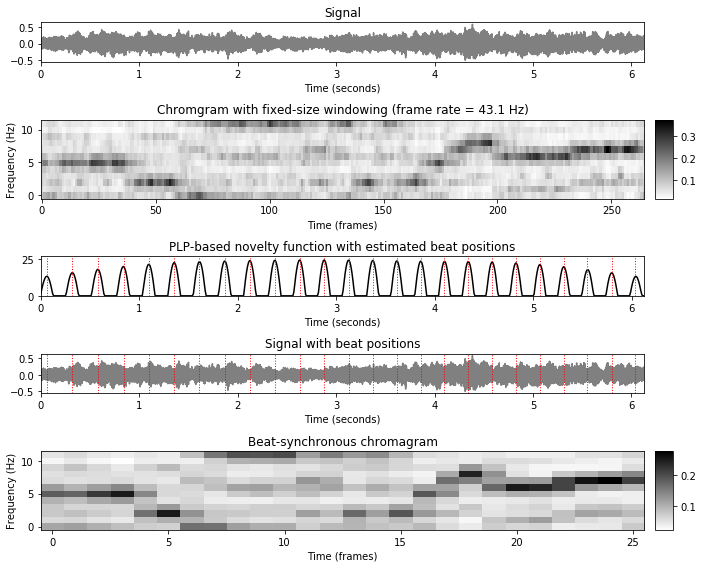

In [3]:
fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F07_Shostakovich_Waltz-02-Section_IncreasingTempo.wav')

Fs = 22050
x, Fs = librosa.load(fn_wav, Fs) 

nov, Fs_nov = LibFMP.C6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, 
                                                 gamma=100, M=10, norm=1)
nov, Fs_nov = LibFMP.C6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

L_nov = len(nov)
N_nov = 500
H_nov = 10
Theta = np.arange(30,601)
X, T_coef, F_coef_BPM = LibFMP.C6.compute_tempogram_Fourier(nov, Fs=Fs_nov, 
                                                            N=500, H=10, Theta=Theta)
nov_PLP = LibFMP.C6.compute_PLP(X, Fs_nov, L_nov, N_nov, H_nov, Theta)
peaks, properties = signal.find_peaks(nov_PLP, prominence=0.02)
B_adapt_sec = peaks / Fs_nov

N, H = 1024, 512
X = librosa.stft(y=x, n_fft=N, hop_length=H, win_length=N, center=True, window='hanning')
Y = np.abs(X)
C = librosa.feature.chroma_stft(S=Y, sr=Fs, norm=1, hop_length=H, n_fft=N)
B_fix_frame = (B_adapt_sec*Fs/H).astype(int)
C_adapt = librosa.util.sync(C, B_fix_frame, aggregate=np.mean)

# Visualization
fig, ax = plt.subplots(5, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1, 2, 1, 1, 2]}, figsize=(10,8)) 

LibFMP.B.plot_signal(x, Fs, ax=ax[0,0], title='Signal')
ax[0,1].set_axis_off()
    
LibFMP.B.plot_matrix(C, ax=[ax[1,0], ax[1,1]], xlabel='Time (frames)', 
                     title='Chromgram with fixed-size windowing (frame rate = %0.1f Hz)'%(Fs/H))

LibFMP.B.plot_signal(nov_PLP, Fs_nov, color='k', ax=ax[2,0],
                    title='PLP-based novelty function with estimated beat positions')
ax[2,1].set_axis_off()
plot_beat_grid(B_adapt_sec, ax[2,0])

LibFMP.B.plot_signal(x, Fs, ax=ax[3,0],
                    title='Signal with beat positions')
ax[3,1].set_axis_off()
plot_beat_grid(B_adapt_sec, ax[3,0]) 

LibFMP.B.plot_matrix(C_adapt, ax=[ax[4,0], ax[4,1]], xlabel='Time (frames)',
                    title='Beat-synchronous chromagram')

plt.tight_layout()

## Transient Removal

Next, we show how the knowledge of onset and beat positions can be used in another way for improving the quality of audio features. Recall that note onsets often go along with **transients** (noise-like energy bursts) spread over the entire spectrum, especially for instruments such as the piano, guitar, or percussion. While transients are useful for the detection of note onset positions, they may cause undesired artifacts in features that capture harmonic or melodic information. To remove these noise-like artifacts while keeping the harmonic information, one idea is to exclude a neighborhood around each note onset position. To this end, we introduce a parameter $\lambda\in\mathbb{R}$, $0<\lambda<1$, which determines the size of the neighborhoods. Let $s,t\in[1:N]$ denote the start and end positions of a given adaptive window. Then we define 

\begin{equation}
   s_\lambda := s + \left\lfloor \frac{1-\lambda}{2}(t-s)\right\rfloor \,\,\,\mbox{and}\,\,\,
   t_\lambda := t - \left\lfloor \frac{1-\lambda}{2}(t-s)\right\rfloor,
\end{equation}

which determine the start and end positions of the shortened window used for the feature computation. With this definition, the center of the adaptive window is preserved, while its size is reduced by a factor $\lambda$ relative to its original size $(t-s)$. 

In the next code cell, one finds an implementation of this procedure applied to the C-major scale used above. As feature representation, we show a magnitude spectrogam using adaptive windowing once using $\lambda=1$ and once using $\lambda=0.5$. In this example, however, the denoising effect by removing signal transients is hardly visible. 

<!--
Will illustrate this effect in our next example, which is a piano recording of a chromatic scale.
<audio src="../data/C6/FMP_C6_F24_ChromaticScaleSlow.mp3" type="audio/mpeg" controls="controls"></audio>
First, we show the original time&ndash;pitch representation using a fixed window size. In this representation, the transients that go along with note onsets are clearly visible as vertical structures at the beginning of each note. Next, we use an adaptive windowing strategy based on consecutive note onset positions. Each of the resulting feature vectors reveals the pitch content of a single note. However, the nonharmonic transient components also enter the analysis window and introduce noise-like artifacts in pitch bands that are not related to the underlying notes. Note that this case corresponds to the case $\lambda=1$. Finally, using the factor $\lambda=0.5$, one obtains a representation, where the transients at the note onset positions are removed. As a result, the harmonic information of the time&ndash;pitch representation has clearly been enhanced.
<img src="../data/C6/FMP_C6_F24_text.png" width="500px" align="middle" alt="FMP_C6_F24_text.png">
-->

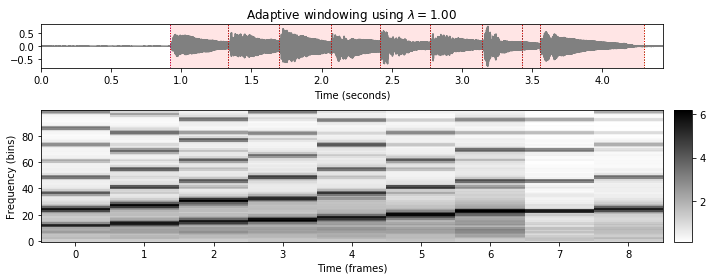

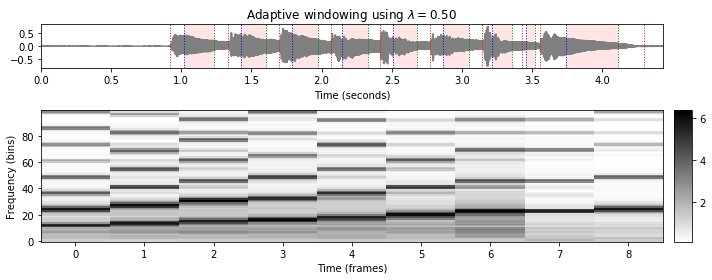

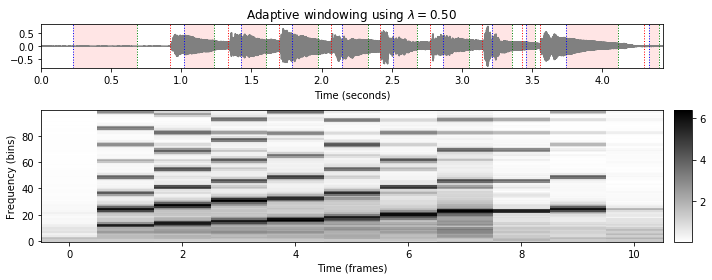

In [4]:
def adaptive_windowing(X, B, neigborhood=1, add_start=False, add_end=False):
    """Apply adaptive windowing [FMP, Section 6.3.3]

    Notebook: C6/C6S3_AdaptiveWindowing.ipynb

    Args:
        X: Feature sequence
        B: Beat sequence (spefied in frames)
        neigborhood: Parameter specifying relative range considered for windowing
        add_start: Add first index of X to beat sequence (if not existent)
        add_end: Add last index of X to beat sequence (if not existent)

    Returns:
        X_adapt: Feature sequence adapted to beat sequence 
        B_s, B_t: Sequences specifying start and end (in frames) of window sections
    """ 
    len_X = X.shape[1]
    max_B = np.max(B)
    if max_B > len_X:
        print('Beat exceeds length of features sequence (b=%d, |X|=%d)'%(max_B,len_X))
        B = B[B<len_X]         
    if add_start:
        if B[0] > 0:
            B = np.insert(B,0,0)                        
    if add_end:
        if B[-1] < len_X:
            B = np.append(B,len_X)
    X_adapt = np.zeros((X.shape[0], len(B)-1))
    B_s = np.zeros(len(B)-1).astype(int)
    B_t = np.zeros(len(B)-1).astype(int)
    for b in range(len(B)-1):
        s = B[b]
        t = B[b+1]
        reduce = np.floor((1 - neigborhood)*(t-s+1)/2).astype(int)
        s = s + reduce
        t = t - reduce
        if s==t: t = t+1   
        X_slice = X[:,range(s,t)]
        a = np.sum(X_slice, axis=1)
        X_adapt[:,b] = np.mean(X_slice, axis=1)
        B_s[b] = s
        B_t[b] = t
    return X_adapt, B_s, B_t

def compute_plot_adaptive_windowing(X, B, neigborhood=1, add_start=False, add_end=False):
    """Compute and plot process for adaptive windowing [FMP, Section 6.3.3]
    Notebook: C6/C6S3_AdaptiveWindowing.ipynb"""    
    X_adapt, B_s, B_t = adaptive_windowing(X, B, neigborhood=neigborhood, 
                                           add_start=add_start, add_end=add_end)
    
    fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                              'height_ratios': [1, 3]}, figsize=(10,4)) 

    LibFMP.B.plot_signal(x, Fs, ax=ax[0,0], 
                         title='Adaptive windowing using $\lambda = %0.2f$'%neigborhood)
    ax[0,1].set_axis_off()
    plot_beat_grid(B_s*H/Fs, ax[0,0], color='b') 
    plot_beat_grid(B_t*H/Fs, ax[0,0], color='g')
    plot_beat_grid(B*H/Fs, ax[0,0], color='r')
    for k in range(len(B_s)):
        ax[0,0].fill_between([B_s[k]*H/Fs,B_t[k]*H/Fs], -1, 1, facecolor='red', alpha=0.1)

    LibFMP.B.plot_matrix(X_adapt, ax=[ax[1,0], ax[1,1]], 
                         xlabel='Time (frames)', ylabel='Frequency (bins)')
    plt.tight_layout()
    return X_adapt

#fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F23_PhrygianHalfCadenceC.wav')
#fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F23_C-major-scale_fast.wav')
fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F24_ScaleMajorC-middle.wav')
#fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F24_ChromaticScaleSlow.wav')

Fs = 22050
x, Fs = librosa.load(fn_wav, Fs) 
N, H = 1024, 256
X = librosa.stft(y=x, n_fft=N, hop_length=H, win_length=N, center=True,window='hanning')
X = X[0:100,:]
Y = np.log(1+ 10*np.abs(X))

nov, Fs_nov = LibFMP.C6.compute_novelty_spectrum(x, Fs=Fs, N=512, H=256, 
                                                 gamma=100, M=10, norm=1)
nov, Fs_nov = LibFMP.C6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

peaks, properties = signal.find_peaks(nov, prominence=0.2)
B_adapt_sec = peaks/Fs_nov

add_start = False
add_end = False
neigborhood = 1
B_adapt_frame = np.round(B_adapt_sec*Fs/H).astype(int)
Y_adapt = compute_plot_adaptive_windowing(Y, B_adapt_frame, 
                        neigborhood=neigborhood, add_start=add_start, add_end=add_end)
neigborhood = 0.5
Y_adapt = compute_plot_adaptive_windowing(Y, B_adapt_frame, 
                        neigborhood=neigborhood, add_start=add_start, add_end=add_end)

add_start = True
add_end = True
neigborhood = 0.5
Y_adapt = compute_plot_adaptive_windowing(Y, B_adapt_frame, 
                        neigborhood=neigborhood, add_start=add_start, add_end=add_end)

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a>.
</div>  

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>